In the following example we will try to address a regression problem. We will use the Boston housing dataset from Keras, and try to predict the price of a house given a set of features. We will use a simple neural network with a single hidden layer.

# Import libraries

In [15]:
from keras.datasets import boston_housing
from keras import models
from keras import layers

import numpy as np

# Import the Boston housing dataset

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 4us/step


In [7]:
print("shape of the training set is :", train_data.shape)

print("shape of the test set is :", test_data.shape)

print("shape of the training targets is :", train_targets.shape)

print("shape of the test targets is :", test_targets.shape)

shape of the training set is : (404, 13)
shape of the test set is : (102, 13)
shape of the training targets is : (404,)
shape of the test targets is : (102,)


In [8]:
# Normalizing the data

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [21]:
# Building the network

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
    input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


This time we'll use K fold validation, one motivation to use this technique is that our dataset is small, so a single validation set would be very small. We will use 4 folds, so we will have 4 validation scores, and we will compute the mean of them.

In [12]:
# K fold validation

k = 4

num_val_samples = len(train_data)//k

num_epochs = 100

all_scores = []

In [22]:
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]],
    axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
    epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [25]:
all_scores
np.mean(all_scores)

2.6627182960510254

If we run the code different times, we will see that the validation scores vary from 2.6 to 3. A mae of 3 means that in average our predictions are 3000 dollars away from the real price, which is a lot considering that the prices range from 10000 to 50000 dollars.Let's try to run the code with 500 epochs and see what happens.

In [30]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]],
    axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
    validation_data=(val_data, val_targets),
    epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [31]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

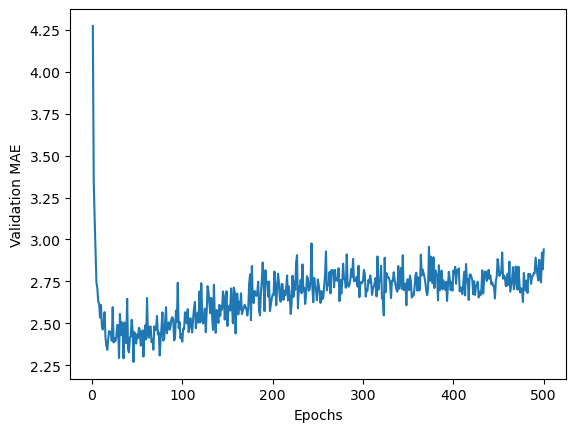

In [32]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

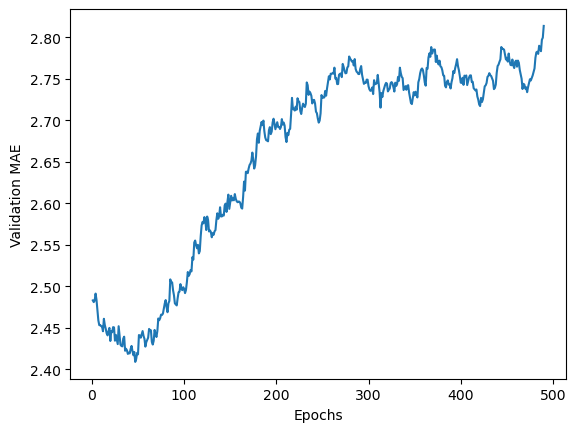

In [33]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to the plot we can see that the validation loss stops improving after 80 epochs, so we are just wasting time and resources by training for 500 epochs.

In [46]:
model = build_model()
model.fit(train_data, train_targets,
epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 16.6353 - mae: 2.6206


In [47]:
test_mae_score

2.6205995082855225

So we are still off by 2600 dollars. It appears we can't do better with this simple model.